# Setup

Ensure all dependencies are installed.


In [1]:
%pip install -U -r requirements.txt

  Cloning ssh://****@gitlab.utwente.nl/s2219735-bsc-research-project/mesh-to-points.git (to revision main) to /tmp/pip-install-g4ugo5h3/m2p_5b752e00480e475e8cafc58d2ada2e76
  Running command git clone --filter=blob:none --quiet 'ssh://****@gitlab.utwente.nl/s2219735-bsc-research-project/mesh-to-points.git' /tmp/pip-install-g4ugo5h3/m2p_5b752e00480e475e8cafc58d2ada2e76
  Resolved ssh://****@gitlab.utwente.nl/s2219735-bsc-research-project/mesh-to-points.git to commit 78899e62db635567c95b5e83565a036f4974d071
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Note: you may need to restart the kernel to use updated packages.


Check if we have GPU support, and if not, warn the user.


In [2]:
import torch
import warnings

if torch.cuda.is_available():
    print("CUDA is available!")
else:
    warnings.warn("CUDA is not available. Running on CPU.")

CUDA is available!


Load our dataset...


In [3]:
import os
from data_sources.modelnet40 import ModelNet40
from models.dataset import PointCloudDataset
from typing import List

train_folder = "data/train"
test_folder = "data/test"

train_dataset: PointCloudDataset = None
test_dataset: PointCloudDataset = None

if os.path.exists(train_folder) and os.path.exists(test_folder):
    print("Train and test data found. Reading data...")
    train_files: List[str] = []
    test_files: List[str] = []

    for root, dirs, files in os.walk(train_folder):
        for file in files:
            train_files.append(os.path.join(root, file))

    for root, dirs, files in os.walk(test_folder):
        for file in files:
            test_files.append(os.path.join(root, file))

    train_dataset = PointCloudDataset(train_files)
    test_dataset = PointCloudDataset(test_files)
    k = 40
else:
    classes, train_dataset, test_dataset = ModelNet40.download(
        npoints=2500, train_outdir=train_folder, test_outdir=test_folder
    )
    k = len(classes)

print(f"Training data: {len(train_dataset)} samples")
print(f"Test data size: {len(test_dataset)} samples")

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
Train and test data found. Reading data...
Training data: 9843 samples
Test data size: 2468 samples


# Training

Train a new classifier or load a new pre-trained one:


In [4]:
from pointnet.train_classification import train_classification
from pointnet.model import PointNetCls

classifier_path = "pointnet/classifier.pth"  # pointnet/classifier.pth

if classifier_path and os.path.exists(classifier_path):
    print(f"Loading existing model from {classifier_path}...")
    classifier = PointNetCls(k=k)
    classifier.load_state_dict(torch.load(classifier_path, weights_only=True))
    print("Classifier loaded successfully.")
else:
    classifier = train_classification(
        train_dataset=train_dataset,
        test_dataset=test_dataset,
        k=k,
        epochs=25,
        outf="./pointnet/cls",
    )

Loading existing model from pointnet/classifier.pth...
Classifier loaded successfully.


Run a simple classification to get a visualization of our classifier.


Scores: [-19.986530303955078, -16.742843627929688, -18.60452651977539, -21.132400512695312, -17.730087280273438, -17.330257415771484, -21.35329246520996, -17.40240478515625, -21.09502410888672, -15.885913848876953, -25.115314483642578, -24.950702667236328, -21.776939392089844, -16.93553924560547, -19.075281143188477, -25.296539306640625, -17.17017364501953, -19.38390350341797, -15.875898361206055, -19.692453384399414, -15.788501739501953, -16.35293960571289, -14.517779350280762, -21.406688690185547, -23.33614158630371, -15.184710502624512, -21.429149627685547, -23.178565979003906, -13.374752044677734, -18.181203842163086, -18.16475486755371, -16.520587921142578, -20.452880859375, -20.42220687866211, -23.13652801513672, -21.49709701538086, -3.099436753473128e-06, -20.393829345703125, -17.33316421508789, -19.45771598815918]
Expected class: 36
Predicted class: 36


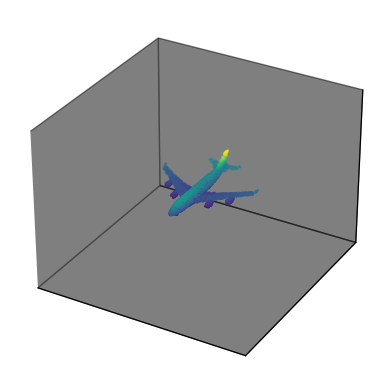

In [5]:
import random
import torch
from utils.plot import plot_points

i = random.randint(0, len(test_dataset) - 1)

input_data = test_dataset[i][0].unsqueeze(0)
input_data = input_data.transpose(1, 2)

classifier.eval()

with torch.no_grad():
    output = classifier(input_data)


scores: torch.Tensor = output[0][0]
print("Scores:", scores.tolist())
print(f"Expected class: {int(test_dataset[i][1])}")
print(f"Predicted class: {scores.argmax().item()}")

points = input_data[0].transpose(0, 1).numpy()
plot_points(points)

Train the segmenter:


In [6]:
from pointnet.train_segmentation import train_segmentation

train_segmentation(
    train_dataset=train_dataset,
    test_dataset=test_dataset,
    k=k,
    epochs=25,
    class_choice=0,
    outf="./pointnet/seg",
)

Random Seed:  2386


ValueError: Expected input batch_size (80000) to match target batch_size (32).